In [2]:
import re
import os, csv, sys 
import scipy
import pandas as pd
import gzip
import xml.etree.ElementTree as ET
from os import listdir
from datetime import datetime
import csv
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

## Create pandaframe from xml files

In [4]:
## Parameters

data_folder = 'data/'
results_folder = 'results/'
figures_folder = 'figures/'

delete_previous_results_files = 'y'
save_csv_files = 'y'  # one per model

In [8]:
# Create folders

for folder_name in [data_folder, results_folder, figures_folder]:
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

        
# Initialise lists

file_list = []
list_failed1 = []
list_st1 = []
models = []
    

# Create list with filenames and delete previously created results files
    
for file in os.listdir(data_folder):
    if '.xml' in file or '.xml.gz' in file:
        xml_file = data_folder+file
        file_list.append(xml_file)
        model = file.split('_')[3].lower()
        if model not in models:
            models.append(model)
            if delete_previous_results_files == 'y':
                try:
                    os.remove(results_folder+model+'_all.csv')
                except:
                    pass
       
    
# Loop over list of filenames         
        
for data in file_list:

    # Model name from filename
    model_name = data.split('_')[3].lower()
    # Define csv file
    csv_file = results_folder+data.split('_')[3].lower()+'_all.csv'

    # Read file
    if data.endswith('.xml'):
        try:
            tree = ET.parse(data)
            root = tree.getroot()
        except:
            list_failed1.append(data)
            pass

    elif data.endswith('.gz'):
        try:
            tree = ET.parse(gzip.open(data))  
            root = tree.getroot()
        except:
            list_failed1.append(data)
            pass

    # Check how many files could not be parsed
    print(len(list_failed1))
    prod_center=root.find('header/productionCenter').text

    ## Create one dictonary for each time point, and append it to a list
    
    for members in root.findall('data'):
        Mtype=members.get('type')
        
        if Mtype in ['forecast','ensembleForecast']:
            for members2 in members.findall('disturbance'):
                for members3 in members2.findall('fix'):
                    tem_dic={}
                    tem_dic['Mtype']=[Mtype]
                    tem_dic['model_name']=[model_name]
                    tem_dic['pro']=[re.sub('\s+',' ',prod_center)]
                    tem_dic['basin']= [name.text for name in members2.findall('basin')]
                    try:
                        tem_dic['cycloneName'] = [name.text.lower().strip() for name in members2.findall('cycloneName')]
                    except:
                        tem_dic['cycloneName'] = [name.text for name in members2.findall('cycloneName')]
                    tem_dic['cycloneNumber'] = [name.text for name in members2.findall('cycloneNumber')]
                    tem_dic['ensemble']=[members.get('member')]#[member]
                    tem_dic['cyc_speed'] = [name.text for name in members3.findall('cycloneData/maximumWind/speed')]
                    #tem_dic['cyc_speed'] = [name.text for name in members3.findall('cycloneData/minimumPressure/pressure')]
                    tem_dic['cyc_cat'] = [name.text for name in members3.findall('cycloneData/development')]
                    tem_dic['validt'] = [name.text for name in members3.findall('validTime')]
                    tem_dic['lat'] = [name.text for name in members3.findall('latitude')]
                    tem_dic['lon']= [name.text for name in members3.findall('longitude')]                
                    tem_dic['vhr']=[members3.get('hour')]
                    validt=members2.get('ID').split('_')[0]
                    date_object = datetime.strptime(validt, "%Y%m%d%H")
                    s1 = date_object.strftime("%m/%d/%Y, %H:00:00")
                    tem_dic['validt2']=[s1]  
                    tem_dic1 = dict( [(k,''.join(str(e).lower().strip() for e in v)) for k,v in tem_dic.items()])
                    list_st1.append(tem_dic1)
                    
        elif Mtype=='analysis':
            for members2 in members.findall('disturbance'):
                tem_dic={}
                tem_dic['Mtype']=['analysis']
                tem_dic['model_name']=[model_name]
                tem_dic['pro']=[prod_center.split('\n')[0]]
                tem_dic['basin']= [name.text for name in members2.findall('basin')]
                try:
                    tem_dic['cycloneName'] = [name.text.lower().strip() for name in members2.findall('cycloneName')]
                except:
                    tem_dic['cycloneName'] = [name.text for name in members2.findall('cycloneName')]
                tem_dic['cycloneNumber'] = [name.text for name in members2.findall('cycloneNumber')]
                tem_dic['ensemble']=['NAN']
                tem_dic['cyc_speed'] = [name.text for name in members2.findall('cycloneData/maximumWind/speed')]
                #tem_dic['cyc_speed'] = [name.text for name in members2.findall('cycloneData/minimumPressure/pressure')]
                tem_dic['cyc_cat'] = [name.text for name in members2.findall('cycloneData/development')]
                tem_dic['validt'] = [name.text for name in members2.findall('fix/validTime')]
                tem_dic['lat'] = [name.text for name in members2.findall('fix/latitude')]
                tem_dic['lon']= [name.text for name in members2.findall('fix/longitude')]
                tem_dic['vhr']=[members2.get('hour')]
                validt=members2.get('ID').split('_')[0]
                date_object = datetime.strptime(validt, "%Y%m%d%H")
                s1 = date_object.strftime("%m/%d/%Y, %H:00:00")
                tem_dic['validt2']=[s1]  
                tem_dic1 = dict( [(k,''.join(str(e).lower().strip() for e in v)) for k,v in tem_dic.items()])
                list_st1.append(tem_dic1)

    # Save the databases to the csv files (one for each model)
    if save_csv_files == 'y':
        
        # Headers
        csv_columns = list_st1[0].keys()

        if os.path.exists(csv_file):
            append_write = 'a' # append if already exists
        else:
            append_write = 'w' # make a new file if not

        # Write data
        try:
            with open(csv_file, append_write) as csvfile:
                writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
                writer.writeheader()
                for data in list_st1:
                    writer.writerow(data)
        except IOError:
            print("I/O error")
            
            
## Create pandas dataframe
df_store=pd.DataFrame(list_st1)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


## Structure the results as a dictionary

Create a dictionary out of the results, with the following sctructure:

- model number:
    - model name
    - cyclone name
        - forecast
            - start (date and time at which the forecast was started)
            - lat (list of latitudes of the path)
            - lon (list of longitudes of the path)
        - ensemble
            - start
            - lat
            - lon
        - ensemble_mean
            - start
            - lat
            - lon

In [18]:
## Parameters

cyclone_names = ['phanfone','vongfong']
time_limit = 72
time_separation = 6

In [20]:
# Initialise the dictonary
results = {}

# Create a list with time points
nhours_list = list(np.linspace(0,time_limit,time_limit/time_separation+1, dtype=int))

# Retrieve model names from the dataframe (the function set removes duplicates from a list)
model_names = list(set(df_store['model_name']))

# Loop over models
for model_num, model_name in enumerate(model_names):
    
    # Initialise subdictionary and assign name
    results[str(model_num)] = {}
    results[str(model_num)]['model_name'] = model_name
    
    # Restrict the dataframe to the specific model
    df_model = df_store[df_store['model_name'] == model_name]
    
    # Loop over cyclone names
    for cyclone_name in cyclone_names:
        
        # Initialise subdictionary
        results[str(model_num)][cyclone_name] = {}
        
        # Restrict the dataframe to the specific cyclone
        df_cyclone = df_model[df_model['cycloneName']==cyclone_name]
        
        # Initialise subdictionary forecast
        results[str(model_num)][cyclone_name]['forecast'] = {}
        
        # Restrict the dataframe to the forecasts
        df_forecast = df_cyclone[df_cyclone['Mtype'] == 'forecast']

        # Initialise lists for lat and lon of paths
        lat_forecast = []
        lon_forecast = []

        # Loop over time points
        for nhours in nhours_list:
            # Assign lat and lon
            try:
                lat_forecast.append(float(df_forecast[df_forecast['vhr']==str(nhours)]['lat']))
                lon_forecast.append(float(df_forecast[df_forecast['vhr']==str(nhours)]['lon']))
            except:
                lat_forecast.append(np.nan)
                lon_forecast.append(np.nan)
                
        # Assign starting point ('validt2' in the dataframe)
        try:
            results[str(model_num)][cyclone_name]['forecast']['start'] = list(df_forecast[df_forecast['vhr']==str(0)]['validt2'])[0] 
        except:
            results[str(model_num)][cyclone_name]['forecast']['start'] = ''
            
        # Store lats and lons in the dictonary
        results[str(model_num)][cyclone_name]['forecast']['lat'] = np.array(lat_forecast)
        results[str(model_num)][cyclone_name]['forecast']['lon'] = np.array(lon_forecast)

        # Initialise subdictionary ensembles
        results[str(model_num)][cyclone_name]['ensemble'] = {}
        
        # Initialise lists for lat and lon of paths
        lat_ensemble_list = []
        lon_ensemble_list = []
        
        # Restrict the dataframe to the ensemble forecasts
        df_ensemble = df_cyclone[df_cyclone['Mtype'] == 'ensembleforecast']

        # For each model, each cyclone, retrieve the list of ensembles
        ensemble_list = sorted([int(x) for x in list(set(df_ensemble['ensemble']))])
        
        # Loop over the member of the ensemble
        for member in ensemble_list:
            
            # Restrict the dataframe to the ensemble
            df_member = df_ensemble[df_ensemble['ensemble'] == str(member)]
            
            # Initialise lists for lat and lon of paths
            lat_member = []
            lon_member = []
            
            # Loop over the time points
            for nhours in nhours_list:
                # Assign lat and lon
                try:
                    lat_member.append(float(df_member[df_member['vhr']==str(nhours)]['lat']))
                    lon_member.append(float(df_member[df_member['vhr']==str(nhours)]['lon']))
                except:
                    lat_member.append(np.nan)
                    lon_member.append(np.nan)

            lat_ensemble_list.append(lat_member)
            lon_ensemble_list.append(lon_member)
           
        # Store lats and lons in the dictonary (as arrays)
        try:
            results[str(model_num)][cyclone_name]['ensemble']['start'] = list(df_member[df_member['vhr']==str(0)]['validt2'])[0]
        except:
            results[str(model_num)][cyclone_name]['ensemble']['start'] = ''
            
        results[str(model_num)][cyclone_name]['ensemble']['lat'] = np.array(lat_ensemble_list)
        results[str(model_num)][cyclone_name]['ensemble']['lon'] = np.array(lon_ensemble_list)

/Users/castellana/anaconda3/envs/python_3/lib/python3.6/site-packages/ipykernel/__main__.py:5: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


In [22]:
## Crete average path over each ensemble

for model_num in range(len(results)):
    for cyclone_name in cyclone_names:
        lat_ens = np.array(results[str(model_num)][cyclone_name]['ensemble']['lat'], dtype=np.float)
        lon_ens = np.array(results[str(model_num)][cyclone_name]['ensemble']['lon'], dtype=np.float)
        results[str(model_num)][cyclone_name]['ensemble_mean'] = {}
        results[str(model_num)][cyclone_name]['ensemble_mean']['start'] = results[str(model_num)][cyclone_name]['ensemble']['start']
        results[str(model_num)][cyclone_name]['ensemble_mean']['lat'] = np.nanmean(lat_ens,0)
        results[str(model_num)][cyclone_name]['ensemble_mean']['lon'] = np.nanmean(lon_ens,0)

/Users/castellana/anaconda3/envs/python_3/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: Mean of empty slice
/Users/castellana/anaconda3/envs/python_3/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: Mean of empty slice


## Plots

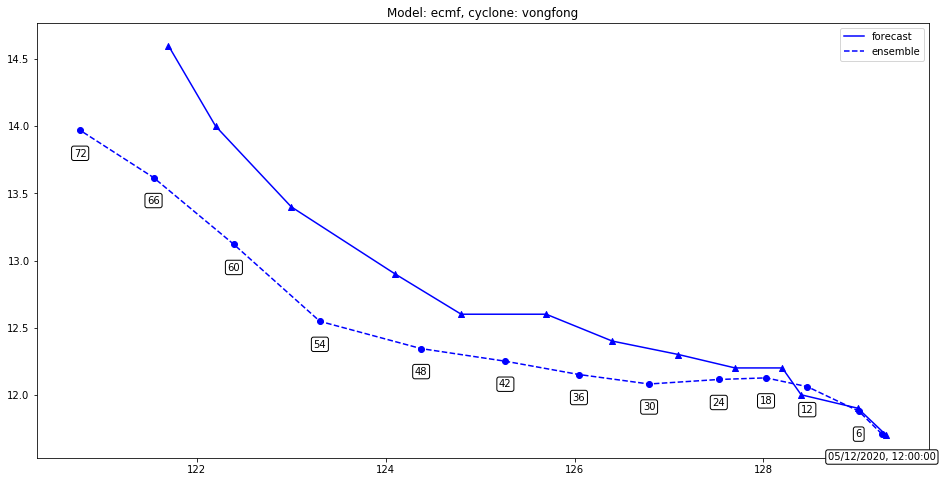

In [23]:
## Plot single cyclone, single model

# Parameters
model_num = 0  #[0,1,2,3]
cyclone_name = 'vongfong'  #['phanfone','vongfong']
colors = ['b', 'r', 'm', 'k']
plot_forecast = 'y'

# Create figure
plt.figure(figsize=(16,8))

# Path relative to the 'forecast'
lat_for = results[str(model_num)][cyclone_name]['forecast']['lat']
lon_for = results[str(model_num)][cyclone_name]['forecast']['lon']

# Path relative to the average 'esemble forecast'
lat_cal = results[str(model_num)][cyclone_name]['ensemble_mean']['lat']
lon_cal = results[str(model_num)][cyclone_name]['ensemble_mean']['lon']
        

if plot_forecast == 'y':
    if lat_for.size > 1 and not all(x == 'nan' for x in lat_for):
        plt.plot(lon_for,lat_for, color=colors[model_num], label='forecast')
        plt.scatter(lon_for,lat_for, color=colors[model_num], marker='^')
    
if lat_cal.size > 1 and not all(x == 'nan' for x in lat_cal):
    plt.plot(lon_cal,lat_cal, '--', color=colors[model_num], label='ensemble')
    plt.scatter(lon_cal,lat_cal, color=colors[model_num])
    
    # Retrieve the date and time at which the forecast was made
    start_ens = results[str(model_num)][cyclone_name]['ensemble']['start']
    
    # Time points labels
    for label, x, y in zip([start_ens]+nhours_list[1:], lon_cal, lat_cal):
        plt.annotate(
            label,
            xy=(x, y), xytext=(0, -23),
            textcoords='offset points', ha='center', va='center',
            bbox=dict(boxstyle='round,pad=0.22', fc='white'),
            )
    
# Title and legend
plt.title('Model: '+results[str(model_num)]['model_name']+', cyclone: '+cyclone_name);
plt.legend();

/Users/castellana/anaconda3/envs/python_3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


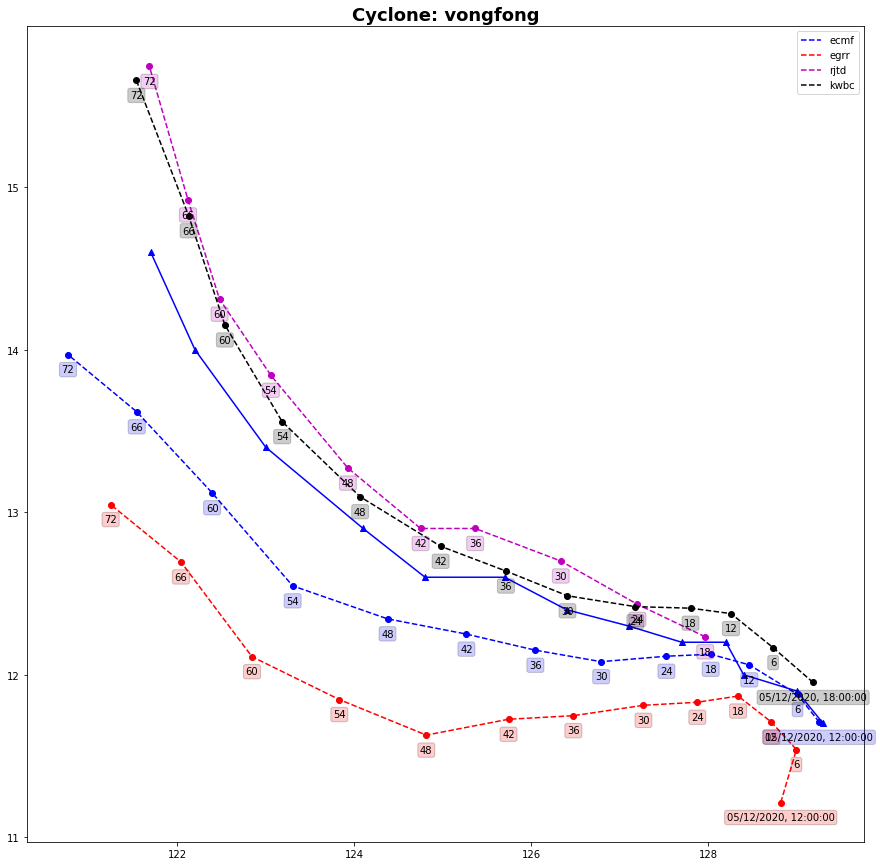

In [29]:
## Plot single cyclone, multimodel

# Parameters
colors = ['b', 'r', 'm', 'k']
cyclone_name = 'vongfong'  #['phanfone','vongfong']
plot_forecast = 'y'

# Create figure
plt.figure(figsize=(15,15))

# Loop over models
for model_num in [0,1,2,3]:

    # Path relative to the 'forecast'
    lat_for = results[str(model_num)][cyclone_name]['forecast']['lat']
    lon_for = results[str(model_num)][cyclone_name]['forecast']['lon']

    # Path relative to the average 'esemble forecast'
    lat_cal = results[str(model_num)][cyclone_name]['ensemble_mean']['lat']
    lon_cal = results[str(model_num)][cyclone_name]['ensemble_mean']['lon']

    if plot_forecast == 'y':
        if lat_for.size > 1 and not all(x == 'nan' for x in lat_for):
            plt.plot(lon_for,lat_for, color=colors[model_num])
            plt.scatter(lon_for,lat_for, color=colors[model_num], marker='^')

    if lat_cal.size > 1 and not all(x == 'nan' for x in lat_cal):
        plt.plot(lon_cal,lat_cal, '--', color=colors[model_num], label=results[str(model_num)]['model_name'])
        plt.scatter(lon_cal,lat_cal, color=colors[model_num])
        
        # Retrieve the date and time at which the forecast was made
        start_ens = results[str(model_num)][cyclone_name]['ensemble_mean']['start']
    
        # Time points labels
        for label, x, y in zip([start_ens]+nhours_list[1:], lon_cal, lat_cal):
            plt.annotate(
                label,
                xy=(x, y), xytext=(0, -15),
                textcoords='offset points', ha='center', va='center',
                bbox=dict(boxstyle='round,pad=0.22', fc=colors[model_num], alpha=0.2),
                )
    
# Title and legend
plt.title('Cyclone: '+cyclone_name, fontweight='bold', fontsize=18)
plt.legend()

/Users/castellana/anaconda3/envs/python_3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


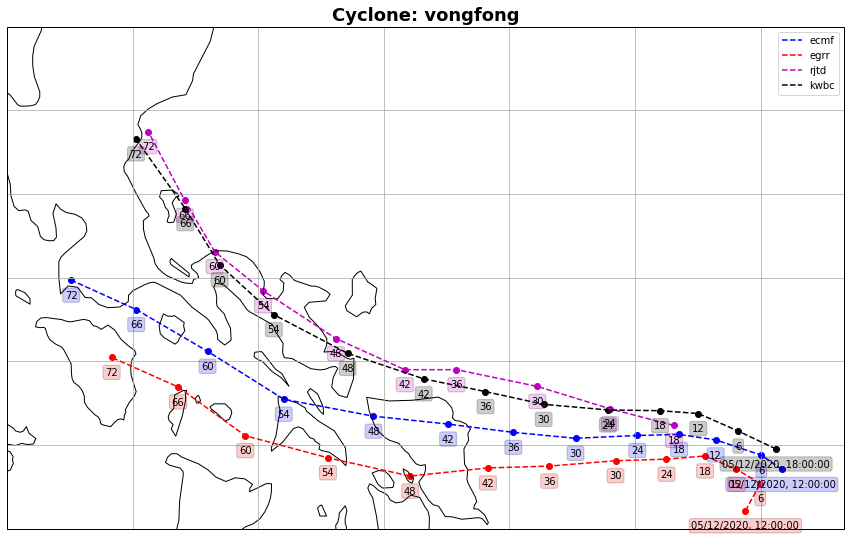

In [31]:
## Plot single cyclone, multimodel, with map

# Parameters
colors = ['b', 'r', 'm', 'k']
cyclone_name = 'vongfong'  #['phanfone','vongfong']
plot_forecast = 'n'

# Create figure
fig = plt.figure(figsize=(15,15))

## Create countours countries
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.stock_img()

# Restrict to certain latitudes - longitudes
ax.set_extent([120, 130, 11, 17], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
ax.gridlines()

# Loop over models
for model_num in [0,1,2,3]:

    # Path relative to the 'forecast'
    lat_for = results[str(model_num)][cyclone_name]['forecast']['lat']
    lon_for = results[str(model_num)][cyclone_name]['forecast']['lon']

    # Path relative to the average 'esemble forecast'
    lat_cal = results[str(model_num)][cyclone_name]['ensemble_mean']['lat']
    lon_cal = results[str(model_num)][cyclone_name]['ensemble_mean']['lon']

    if plot_forecast == 'y':
        if lat_for.size > 1 and not all(x == 'nan' for x in lat_for):
            ax.plot(lon_for,lat_for, color=colors[model_num], transform=ccrs.Geodetic())
            ax.scatter(lon_for,lat_for, color=colors[model_num])

    if lat_cal.size > 1 and not all(x == 'nan' for x in lat_cal):
        ax.plot(lon_cal,lat_cal, '--', color=colors[model_num], label=results[str(model_num)]['model_name'], transform=ccrs.Geodetic())
        ax.scatter(lon_cal,lat_cal, color=colors[model_num])
        
        # Retrieve the date and time at which the forecast was made
        start_ens = results[str(model_num)][cyclone_name]['ensemble_mean']['start']
    
        # Time points labels
        for label, x, y in zip([start_ens]+nhours_list[1:], lon_cal, lat_cal):
            ax.annotate(
                label,
                xy=(x, y), xytext=(0, -15),
                textcoords='offset points', ha='center', va='center',
                bbox=dict(boxstyle='round,pad=0.22', fc=colors[model_num], alpha=0.2),
                )
    
# Title and legend
plt.title('Cyclone: '+cyclone_name, fontweight='bold', fontsize=18)
plt.legend()

In [32]:
## Save figure




/Users/castellana/anaconda3/envs/python_3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


## List cyclones and associated numbers

In [33]:
c = {}
names = []

for row in list_st1:
    name = row['cycloneName'].lower().strip()
    number = row['cycloneNumber']
    try:
        number = int(number)
    except:
        pass
    if name not in names:
        names.append(name)
        c[name] = []
    if number not in c[name]:
        c[name].append(number)

names.sort()
        
from collections import OrderedDict

c_ordered = OrderedDict()
for name in names:
    c_ordered[name] = c[name]
    
print('List cyclones and associated numbers\n')
for k in c_ordered.items():
    print(k)

List cyclones and associated numbers

('', ['', 70, 71, 72, 73, 74, 75, 76, 4, 1, 77, 78, 79, 80, 81, 82])
('01w', [1])
('96s', [96])
('calvinia', [5, 4])
('five', [5])
('invest', [96])
('none', [''])
('one', [1, 32])
('phanfone', [30, 29])
('sarai', [4])
('vongfong', [1])
